In [22]:
%matplotlib inline
from sklearn import datasets
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split, GridSearchCV, learning_curve 
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import GaussianNB,MultinomialNB,BernoulliNB
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix


In [5]:
raw_data = datasets.load_wine()
raw_data

{'DESCR': 'Wine Data Database\n====================\n\nNotes\n-----\nData Set Characteristics:\n    :Number of Instances: 178 (50 in each of three classes)\n    :Number of Attributes: 13 numeric, predictive attributes and the class\n    :Attribute Information:\n \t\t- 1) Alcohol\n \t\t- 2) Malic acid\n \t\t- 3) Ash\n\t\t- 4) Alcalinity of ash  \n \t\t- 5) Magnesium\n\t\t- 6) Total phenols\n \t\t- 7) Flavanoids\n \t\t- 8) Nonflavanoid phenols\n \t\t- 9) Proanthocyanins\n\t\t- 10)Color intensity\n \t\t- 11)Hue\n \t\t- 12)OD280/OD315 of diluted wines\n \t\t- 13)Proline\n        \t- class:\n                - class_0\n                - class_1\n                - class_2\n\t\t\n    :Summary Statistics:\n    \n    ============================= ==== ===== ======= =====\n                                   Min   Max   Mean     SD\n    ============================= ==== ===== ======= =====\n    Alcohol:                      11.0  14.8    13.0   0.8\n    Malic Acid:                   0.74  5.80   

In [6]:
print(raw_data['DESCR'])

Wine Data Database

Notes
-----
Data Set Characteristics:
    :Number of Instances: 178 (50 in each of three classes)
    :Number of Attributes: 13 numeric, predictive attributes and the class
    :Attribute Information:
 		- 1) Alcohol
 		- 2) Malic acid
 		- 3) Ash
		- 4) Alcalinity of ash  
 		- 5) Magnesium
		- 6) Total phenols
 		- 7) Flavanoids
 		- 8) Nonflavanoid phenols
 		- 9) Proanthocyanins
		- 10)Color intensity
 		- 11)Hue
 		- 12)OD280/OD315 of diluted wines
 		- 13)Proline
        	- class:
                - class_0
                - class_1
                - class_2
		
    :Summary Statistics:
    
    ============================= ==== ===== ======= =====
                                   Min   Max   Mean     SD
    ============================= ==== ===== ======= =====
    Alcohol:                      11.0  14.8    13.0   0.8
    Malic Acid:                   0.74  5.80    2.34  1.12
    Ash:                          1.36  3.23    2.36  0.27
    Alcalinity of Ash: 

In [7]:
for item in raw_data:
    print(item)
    print(raw_data[item])

target_names
['class_0' 'class_1' 'class_2']
data
[[  1.42300000e+01   1.71000000e+00   2.43000000e+00 ...,   1.04000000e+00
    3.92000000e+00   1.06500000e+03]
 [  1.32000000e+01   1.78000000e+00   2.14000000e+00 ...,   1.05000000e+00
    3.40000000e+00   1.05000000e+03]
 [  1.31600000e+01   2.36000000e+00   2.67000000e+00 ...,   1.03000000e+00
    3.17000000e+00   1.18500000e+03]
 ..., 
 [  1.32700000e+01   4.28000000e+00   2.26000000e+00 ...,   5.90000000e-01
    1.56000000e+00   8.35000000e+02]
 [  1.31700000e+01   2.59000000e+00   2.37000000e+00 ...,   6.00000000e-01
    1.62000000e+00   8.40000000e+02]
 [  1.41300000e+01   4.10000000e+00   2.74000000e+00 ...,   6.10000000e-01
    1.60000000e+00   5.60000000e+02]]
target
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

In [8]:
raw_data['data'].shape,raw_data['target'].shape

((178, 13), (178,))

In [9]:
features = pd.DataFrame(data=raw_data['data'],columns=raw_data['feature_names'])
data = features
data['target']=raw_data['target']
data['class']=data['target'].map(lambda ind: raw_data['target_names'][ind])
data.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target,class
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0,class_0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0,class_0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0,class_0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0,class_0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0,class_0


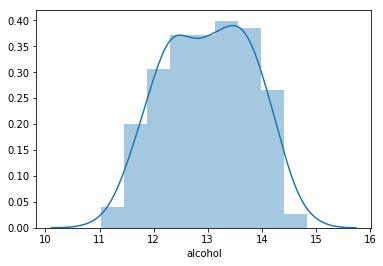

In [10]:
sns.distplot(data['alcohol'])


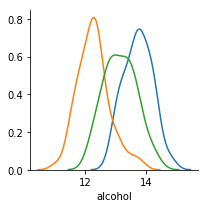

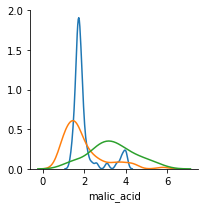

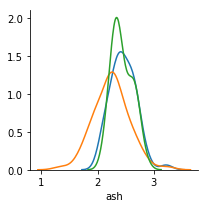

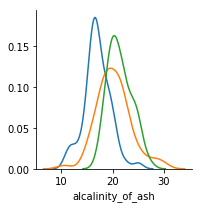

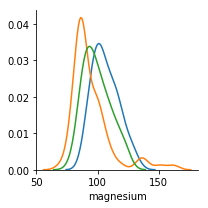

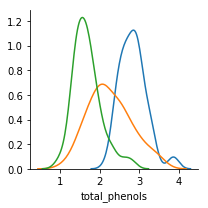

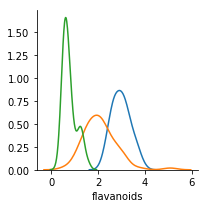

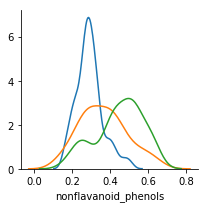

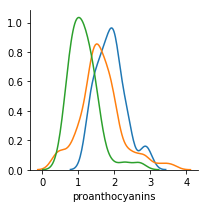

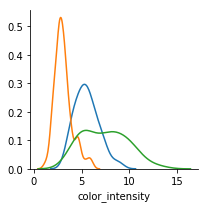

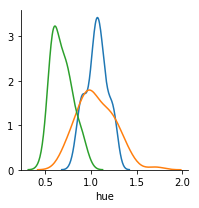

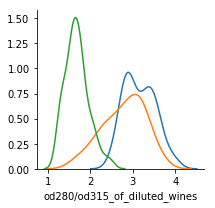

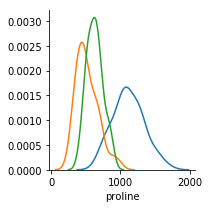

In [11]:
for feature in raw_data['feature_names']:
    facet = sns.FacetGrid(data=data,hue='class')
    facet.map(sns.kdeplot,feature)

In [12]:
data_train, data_test, label_train, label_test = \
    train_test_split(raw_data['data'],raw_data['target'],test_size=0.2)
print len(data_train), len(data_test)

142 36


In [13]:
pipeline=Pipeline([
    ('classifier', GaussianNB()) # Naive Bayes Classifier
])
params = {}

In [14]:
scores = cross_val_score(pipeline, # convert raw messages to a model
                        data_train, # training data
                        label_train, # training labels
                        cv = 10, # split into 10 groups: 9 for training, 1 for testing
                        scoring = 'accuracy', # scoring metric
                        n_jobs = -1
                        )
print scores

[ 0.93333333  0.93333333  1.          1.          0.93333333  0.92857143
  0.92857143  1.          1.          1.        ]


In [15]:
grid = GridSearchCV(pipeline, # convert raw messages to a model
                      params,
                      refit=True,
                        cv = 10, # split into 10 groups: 9 for training, 1 for testing
                        scoring = 'accuracy', # scoring metric
                        n_jobs = -1
                        )


In [16]:
% time wine_detector = grid.fit(data_train,label_train)

CPU times: user 146 ms, sys: 49.5 ms, total: 195 ms
Wall time: 294 ms


In [17]:
% time wine_detector = GaussianNB().fit(data_train,label_train)

CPU times: user 2.58 ms, sys: 1.32 ms, total: 3.9 ms
Wall time: 3.16 ms


In [18]:
predictions = wine_detector.predict(data_test)


In [19]:
print 'accuracy', accuracy_score(label_test, predictions)
print 'confusion matrix\n', confusion_matrix(label_test, predictions)
print '(row=expected, col=predicted)'

accuracy 1.0
confusion matrix
[[11  0  0]
 [ 0 16  0]
 [ 0  0  9]]
(row=expected, col=predicted)


In [20]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and traning learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : integer, cross-validation generator, optional
        If an integer is passed, it is the number of folds (defaults to 3).
        Specific cross-validation objects can be passed, see
        sklearn.cross_validation module for the list of possible objects

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt


CPU times: user 240 ms, sys: 59.6 ms, total: 300 ms
Wall time: 434 ms


<module 'matplotlib.pyplot' from '/anaconda3/envs/py27/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

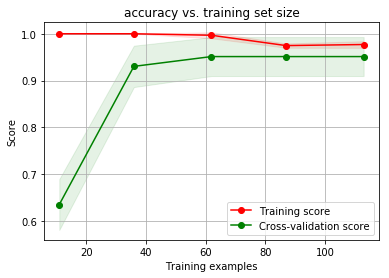

In [23]:
%time plot_learning_curve(pipeline, "accuracy vs. training set size", data_train, label_train, cv=5)